In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.signal import spectrogram
from scipy.io import loadmat
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from scipy.signal import butter, filtfilt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


In [65]:
class TTTEEGBlock(nn.Module):
    def __init__(self, hidden_size, num_heads=4, head_dim=None, eta=0.001, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = head_dim if head_dim is not None else hidden_size // num_heads
        self.eta = eta
        
        # Initialize with better weight scaling
        self.W1 = nn.Parameter(torch.randn(num_heads, self.head_dim, self.head_dim) / np.sqrt(self.head_dim))
        self.b1 = nn.Parameter(torch.zeros(num_heads, 1, self.head_dim))
        
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, cache_params=None):
        B, L, C = x.shape
        
        x = self.layer_norm(x)
        x = x.reshape(B, L, self.num_heads, self.head_dim)
        x = x.permute(0, 2, 1, 3)  # [B, H, L, D]
        
        if cache_params is None:
            output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, self.W1) + self.b1.unsqueeze(0))
        else:
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                output_temp = torch.einsum('bhld,hdf->bhlf', x_temp, self.W1) + self.b1.unsqueeze(0)
                
                # Self-supervised loss: L2 loss + consistency loss
                l2_loss = output_temp.pow(2).mean()
                # Fix: Ensure proper dimensions for consistency loss
                mean_output = output_temp.mean(dim=-1, keepdim=True)  # [B, H, L, 1]
                consistency_loss = torch.abs(output_temp - mean_output).mean()
                self_supervised_loss = l2_loss + 0.1 * consistency_loss
                
                # Compute gradients for self-supervised loss
                grads = torch.autograd.grad(self_supervised_loss, [self.W1, self.b1], retain_graph=True, create_graph=False)
                grad_W1, grad_b1 = grads
                
                grad_W1 = torch.clamp(grad_W1, -1.0, 1.0)
                grad_b1 = torch.clamp(grad_b1, -1.0, 1.0)
                
                if f'W1_states_{id(self)}' not in cache_params:
                    cache_params[f'W1_states_{id(self)}'] = self.W1.clone()
                    cache_params[f'b1_states_{id(self)}'] = self.b1.clone()
                    cache_params[f'momentum_W1_{id(self)}'] = torch.zeros_like(self.W1)
                    cache_params[f'momentum_b1_{id(self)}'] = torch.zeros_like(self.b1)
                
                momentum = 0.9
                cache_params[f'momentum_W1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_W1_{id(self)}'] + 
                    (1 - momentum) * grad_W1
                )
                cache_params[f'momentum_b1_{id(self)}'] = (
                    momentum * cache_params[f'momentum_b1_{id(self)}'] + 
                    (1 - momentum) * grad_b1
                )
                
                cache_params[f'W1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_W1_{id(self)}']
                cache_params[f'b1_states_{id(self)}'] -= self.eta * cache_params[f'momentum_b1_{id(self)}']
                
                output = self.dropout(torch.einsum('bhld,hdf->bhlf', x, 
                                    cache_params[f'W1_states_{id(self)}']) + 
                                    cache_params[f'b1_states_{id(self)}'].unsqueeze(0))
        
        output = output.permute(0, 2, 1, 3)  # [B, L, H, D]
        output = output.reshape(B, L, -1)     # [B, L, H*D]
        
        return output + x.permute(0, 2, 1, 3).reshape(B, L, -1)  # Residual connection

In [66]:
# Load EEG data from .mat files
def load_mat_data(file_path):
    data = loadmat(file_path)['data'][0]
    inputs, targets = [], []
    map = {}
    current = 3
    for i in range(len(data)):
        y = data[i].flatten()
        sub = y[0][0]
        if y[1][0]=='letter-composing':
            continue
        if y[2][0] not in ['trial 1','trial 2','trial 3']:
            continue
        eeg_data = y[3][:6, :]
        if sub not in map:
            map[sub] = current
            current += 1
        targets.append(map[sub])
        inputs.append(eeg_data)
    return np.array(inputs), np.array(targets)

def preprocess_eeg(eeg_data):
    eeg_data = (eeg_data - np.mean(eeg_data)) / (np.std(eeg_data) + 1e-8)
    nyq = 0.5 * 256
    low, high = 0.5 / nyq, 45 / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, eeg_data)

# Load EEG data from folder structure
def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        for i in range(6):
                            X.append(eeg_data[3750:6250, i])
                            y.append(subject_idx)
    return np.array(X), np.array(y)

# Data Augmentation Functions
def jitter(x, sigma=0.01):
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)

def scaling(x, sigma=0.1):
    factor = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], 1))
    return x * factor


def create_spectrogram(eeg_data, fs=256, target_area=2500, num_frequencies=50, num_times=50):   
    # Calculate the segment length (nperseg) based on the desired number of frequency bins
    # The formula for frequency bins is: number of bins = nperseg / 2 + 1
    required_nperseg = (num_frequencies - 1) * 2  # Desired frequency bins and corresponding nperseg

    # Ensure nperseg doesn't exceed the total signal length
    nperseg = min(required_nperseg, len(eeg_data))

    noverlap = nperseg // 2  # Overlap (half of segment length by default)

    # Compute the spectrogram
    frequencies, times, Sxx = spectrogram(
        eeg_data, fs=fs, window='hamming', nperseg=nperseg, noverlap=noverlap, detrend='constant', scaling='density'
    )

    # Ensure we get the expected number of frequency bins
    if Sxx.shape[0] < num_frequencies:
        print(f"Warning: Expected {num_frequencies} frequency bins, but got {Sxx.shape[0]}. Padding with zeros.")
        padding = num_frequencies - Sxx.shape[0]
        Sxx = np.pad(Sxx, ((0, padding), (0, 0)), mode='constant')
    elif Sxx.shape[0] > num_frequencies:
        # If the number of frequency bins is more than desired, truncate
        Sxx = Sxx[:num_frequencies, :]

    # Ensure the number of time bins matches the desired number
    if Sxx.shape[1] < num_times:
        padding = num_times - Sxx.shape[1]
        Sxx = np.pad(Sxx, ((0, 0), (0, padding)), mode='constant')
    elif Sxx.shape[1] > num_times:
        # Trim time bins if there are more than desired
        Sxx = Sxx[:, :num_times]

    # Convert to decibels
    Sxx = 10 * np.log10(Sxx + 1e-5)

    # Normalize the spectrogram
    Sxx = (Sxx - Sxx.min()) / (Sxx.max() - Sxx.min() + 1e-8)
    return Sxx

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class TTTCell(nn.Module):
    def __init__(self, input_size, hidden_size, eta=0.001):
        super().__init__()
        self.hidden_size = hidden_size
        self.eta = eta
        
        # Hidden state model (f in the paper)
        self.hidden_model = nn.Sequential(
            nn.Linear(input_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.GELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )
        
        # Initialize cache for test-time updates
        self.cache_params = {}
        
    def forward(self, x, hidden, is_training=True):
        if is_training:
            next_hidden = self.hidden_model(x)
        else:
            # Test-time training update
            with torch.enable_grad():
                x_temp = x.detach().requires_grad_()
                pred = self.hidden_model(x_temp)
                
                # Self-supervised loss (as described in paper section 2.1)
                l2_loss = pred.pow(2).mean()
                consistency_loss = torch.abs(pred - x_temp.mean(dim=-1, keepdim=True)).mean()
                loss = l2_loss + 0.1 * consistency_loss
                
                # Update hidden model parameters
                grads = torch.autograd.grad(loss, self.hidden_model.parameters())
                
                with torch.no_grad():
                    for param, grad in zip(self.hidden_model.parameters(), grads):
                        if f'momentum_{id(param)}' not in self.cache_params:
                            self.cache_params[f'momentum_{id(param)}'] = torch.zeros_like(param)
                        
                        # Momentum update
                        self.cache_params[f'momentum_{id(param)}'].mul_(0.9).add_(grad, alpha=0.1)
                        param.add_(self.cache_params[f'momentum_{id(param)}'], alpha=-self.eta)
                
                next_hidden = self.hidden_model(x)
                
        return next_hidden


class TTTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Create TTT cells for each layer
        self.cells = nn.ModuleList([
            TTTCell(
                input_size if i == 0 else hidden_size,
                hidden_size
            ) for i in range(num_layers)
        ])
    
    def forward(self, x, hidden=None, is_training=True):
        batch_size, seq_len, _ = x.shape
        
        if hidden is None:
            hidden = [torch.zeros(batch_size, self.hidden_size).to(x.device)
                     for _ in range(self.num_layers)]
        
        outputs = []
        for t in range(seq_len):
            layer_input = x[:, t, :]
            for layer_idx, cell in enumerate(self.cells):
                hidden[layer_idx] = cell(layer_input, hidden[layer_idx], is_training)
                layer_input = hidden[layer_idx]
            outputs.append(layer_input)
            
        outputs = torch.stack(outputs, dim=1)
        return outputs, hidden


class EEGClassifier(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, dropout_prob=0.5):
        super().__init__()
        self.cache_params = {}
        
        # Deeper feature extractor with residual connections
        self.feature_extractor = nn.Sequential(
            # Initial block
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 25x25
            
            # First residual block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12
            
            # Second residual block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 6x6
            
            # Third block with global pooling
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Multiple TTT blocks for better adaptation
        self.ttt_blocks = nn.ModuleList([
            TTTEEGBlock(hidden_size=512, num_heads=8, head_dim=64)
            for _ in range(3)  # Increased number of TTT blocks
        ])
        
        # Enhanced classifier with dropout
        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )
        
        # Improved decoder for better reconstruction
        self.decoder = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 50 * 50)
        )    
    def forward(self, x, is_source=True):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        # Extract features
        features = self.feature_extractor(x)
        features = features.squeeze(-1).squeeze(-1)  # [B, 256]
        features = features.unsqueeze(1)  # [B, 1, 256]
        
        # Apply TTT blocks with domain-specific behavior
        for block in self.ttt_blocks:
            features = block(features, self.cache_params if not is_source else None)
        
        features = features.squeeze(1)  # [B, 256]
        
        # Classification
        logits = self.classifier(features)
        
        # Reconstruction
        recon = self.decoder(features)
        recon = recon.view(-1, 1, 50, 50)
        
        return logits, recon
    
def SEBlock(channels):
    return nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(channels, channels, kernel_size=1),
        nn.Sigmoid()
    )


def ResidualBlock(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.GELU(),
        SEBlock(out_channels),
    )
    
def frequency_mask(x, max_width=5):
    """Apply frequency masking"""
    freq_size = x.shape[0]
    width = np.random.randint(1, max_width)
    start = np.random.randint(0, freq_size - width)
    x_masked = x.copy()
    x_masked[start:start+width, :] = 0
    return x_masked

def time_mask(x, max_width=5):
    """Apply time masking"""
    time_size = x.shape[1]
    width = np.random.randint(1, max_width)
    start = np.random.randint(0, time_size - width)
    x_masked = x.copy()
    x_masked[:, start:start+width] = 0
    return x_masked
    
def test_time_adaptation(model, test_loader, adaptation_steps=5, adaptation_lr=0.001):
    """
    Perform test-time adaptation on the model using the test data.
    """
    model.eval()  # Set to eval mode but still allow gradient computation
    
    # Initialize momentum buffer for each parameter
    momentum_buffer = {}
    for name, param in model.named_parameters():
        if param.requires_grad:
            momentum_buffer[name] = torch.zeros_like(param)
    
    beta = 0.9  # momentum coefficient
    
    for inputs, _ in test_loader:
        inputs = inputs.float()
        
        # Perform multiple adaptation steps
        for _ in range(adaptation_steps):
            # Forward pass with gradient computation
            with torch.enable_grad():
                outputs, recon = model(inputs, is_source=False)
                
                # Compute self-supervised loss
                l2_loss = outputs.pow(2).mean()
                consistency_loss = torch.abs(outputs - outputs.mean(dim=-1, keepdim=True)).mean()
                loss = l2_loss + 0.1 * consistency_loss
                
                # Compute gradients
                loss.backward()
                
                # Update parameters with momentum
                with torch.no_grad():
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            # Update momentum buffer
                            momentum_buffer[name] = beta * momentum_buffer[name] + \
                                                  (1 - beta) * param.grad
                            
                            # Update parameters
                            param.data.add_(momentum_buffer[name], alpha=-adaptation_lr)
                
                # Zero gradients for next step
                model.zero_grad()
    
    return model

In [68]:
def train_model(model, train_loader, val_loader, test_loader, num_epochs=100, learning_rate=0.001):
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    
    # One cycle learning rate schedule
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=learning_rate,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,  # Warm-up for 30% of training
        div_factor=25,  # Initial lr = max_lr/25
        final_div_factor=1000  # Final lr = initial_lr/1000
    )
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
    
    best_val_acc = 0
    patience = 15
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.float()
            
            # Apply mixup with higher alpha
            alpha = 0.4
            lam = np.random.beta(alpha, alpha)
            batch_size = inputs.size()[0]
            index = torch.randperm(batch_size)
            mixed_x = lam * inputs + (1 - lam) * inputs[index]
            
            optimizer.zero_grad()
            
            # Use mixed precision training
            with torch.cuda.amp.autocast():
                outputs, recon = model(mixed_x, is_source=True)
                loss = lam * criterion(outputs, labels) + (1 - lam) * criterion(outputs, labels[index])
                loss += 0.05 * F.mse_loss(recon, inputs)  # Reduced reconstruction weight
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            
            scheduler.step()
            running_loss += loss.item()
        
        # Validation with increased TTT steps
        model.eval()
        val_correct = 0
        val_total = 0
        
        model = test_time_adaptation(model, val_loader, adaptation_steps=15)
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float()
                outputs, _ = model(inputs, is_source=False)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_accuracy = 100. * val_correct / val_total
        print(f'\nEpoch {epoch+1}, Validation Accuracy: {val_accuracy:.2f}%')
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_accuracy,
            }, 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                checkpoint = torch.load('best_model.pth')
                model.load_state_dict(checkpoint['model_state_dict'])
                break
    
    return model

In [69]:
class EEGDataset(Dataset):
    def __init__(self, data, labels, augment=False):
        self.data = []
        self.labels = []
        
        for i, eeg in enumerate(tqdm(data, desc="Creating spectrograms")):
            for channel in range(eeg.shape[0]):
                spectrogram = create_spectrogram(preprocess_eeg(eeg[channel]))
                if augment:
                    # Add more augmentations
                    specs = [
                        spectrogram,
                        jitter(spectrogram, sigma=0.01),
                        scaling(spectrogram, sigma=0.1),
                        add_noise(spectrogram, noise_level=0.01),
                        time_warp(spectrogram, sigma=2)
                    ]
                    for spec in specs:
                        self.data.append(spec)
                        self.labels.append(labels[i])
                else:
                    self.data.append(spectrogram)
                    self.labels.append(labels[i])
        
        self.data = torch.FloatTensor(np.stack(self.data))
        self.data = self.data.unsqueeze(1)
        self.labels = torch.LongTensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def add_noise(x, noise_level=0.01):
    return x + np.random.randn(*x.shape) * noise_level

def time_warp(x, sigma=2):
    """Apply time warping to a 2D spectrogram."""
    x = np.array(x)
    if len(x.shape) != 2:
        raise ValueError(f"Expected 2D input, got shape {x.shape}")
        
    time_steps = np.arange(x.shape[1])
    # Generate random warping
    warp = np.random.normal(loc=1.0, scale=sigma, size=(1,))
    warp_steps = time_steps * warp
    
    # Ensure warp_steps are within bounds
    warp_steps = np.clip(warp_steps, 0, x.shape[1]-1)
    
    # Apply warping to each frequency bin
    warped = np.zeros_like(x)
    for i in range(x.shape[0]):
        warped[i, :] = np.interp(time_steps, warp_steps, x[i, :])
    
    return warped

def jitter(x, sigma=0.01):
    """Add random jitter noise."""
    return x + np.random.normal(0, sigma, x.shape)

def scaling(x, sigma=0.1):
    """Apply random scaling."""
    factor = np.random.normal(1.0, sigma)
    return x * factor

In [70]:
def load_eeg_data(file_path, target_range=(0, 500)):
    """Load EEG data from OpenBCI-RAW files and shift to desired range"""
    try:
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np

        # Skip header rows and load only first 6 EEG channels
        data = pd.read_csv(file_path, skiprows=6)
        eeg_data = data.iloc[:, 1:7].values
        
        # Shift and scale EEG data to the desired range
        eeg_min, eeg_max = eeg_data.min(), eeg_data.max()
        scaled_eeg_data = (eeg_data - eeg_min) / (eeg_max - eeg_min)  # Normalize to [0, 1]
        scaled_eeg_data = scaled_eeg_data * (target_range[1] - target_range[0]) + target_range[0]
        
        # Plot the scaled data
        # plt.figure(figsize=(12, 8))
        # for i in range(6):
        #     plt.subplot(6, 1, i + 1)
        #     plt.plot(scaled_eeg_data[:, i], linewidth=0.5)
        #     plt.title(f'Channel {i + 1}')
        #     plt.ylim(target_range[0], target_range[1])  # Set y-limits to match the target range
        #     plt.ylabel("Amplitude")
        # plt.tight_layout()
        # plt.show()

        return scaled_eeg_data
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

def load_folder_data(root_path, tasks=['baseline', 'counting', 'logical', 'rotation']):
    root = Path(root_path)
    X, y = [], []
    subjects = [d for d in root.iterdir() if d.is_dir() and d.name in ['eshwa', 'Giri', 'Nithish']]
    
    for subject_idx, subject in enumerate(subjects):
        for task in tasks:
            session_pattern = f"OpenBCISession_{subject.name.lower()}_{task}_*"
            sessions = list(subject.glob(session_pattern))
            
            for session in sessions:
                raw_files = list(session.glob("OpenBCI-RAW-*.txt"))
                
                for raw_file in raw_files:
                    eeg_data = load_eeg_data(raw_file)
                    if eeg_data is not None:
                        # Ensure we have enough data to slice 2500 samples
                        if eeg_data.shape[0] >= 6250:
                            # Extract 2500 samples from each of the 6 channels
                            X.append(eeg_data[3750:6250, :6])  # Assuming 6 channels
                            y.append(subject_idx)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Check if we have the desired number of samples
    if X.shape[0] != 36:
        print(f"Warning: Expected 36 samples, but got {X.shape[0]}")
    
    return X, y
    
mat_inputs, mat_targets = load_mat_data('eegdata.mat')
folder_inputs, folder_targets = load_folder_data('dataset')

# Ensure both datasets havl̥e the same number of dimensions
if mat_inputs.ndim == 3 and folder_inputs.ndim == 2:
    folder_inputs = folder_inputs[:, np.newaxis, :]  # Add a new axis to match dimensions

print(mat_inputs.shape,np.unique(mat_targets))

folder_inputs = folder_inputs.transpose(0, 2, 1)
print(folder_inputs.shape,np.unique(folder_targets))
X = np.concatenate((folder_inputs,mat_inputs), axis=0)
y = np.concatenate((folder_targets,mat_targets), axis=0)

# Print class and data shapes
print(f"Class shape: {y.shape}")
print(f"Data shape: {X.shape}")

# Prepare data loaders
dataset = EEGDataset(X, y, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


(84, 6, 2500) [3 4 5 6 7 8 9]
(36, 6, 2500) [0 1 2]
Class shape: (120,)
Data shape: (120, 6, 2500)


Creating spectrograms: 100%|██████████| 120/120 [00:01<00:00, 105.45it/s]


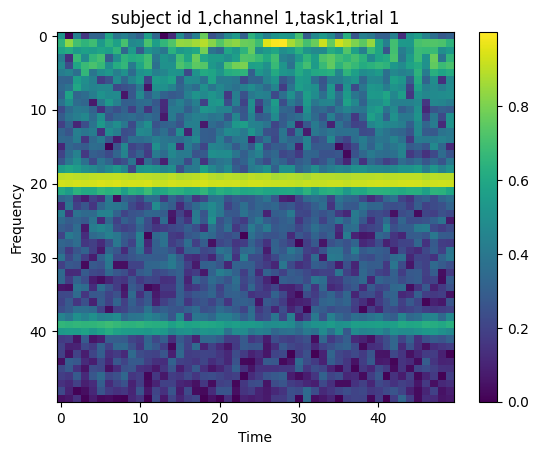

0


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [71]:
plt.imshow(create_spectrogram(X[0][0]), aspect='auto', cmap='viridis')
plt.title('subject id 1,channel 1,task1,trial 1')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()
print(y[0])
y

In [72]:
# Update dataset creation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create source and target datasets
dataset = EEGDataset(X, y, augment=True)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=16, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=False
)

# Initialize model
num_classes = 10
model = EEGClassifier(
    input_channels=1,
    num_classes=num_classes,
    dropout_prob=0.5
)

# Train model with TTT
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Add test loader
    num_epochs=20,
    learning_rate=0.001
)

# Evaluation with TTT adaptation
def evaluate_with_ttt(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    # Perform test-time adaptation
    model = test_time_adaptation(model, data_loader)
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float()
            outputs, _ = model(inputs, is_source=False)  # Use target domain mode
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_preds, all_labels

# Evaluate on test set
print("Evaluating model on test set...")
test_preds, test_labels = evaluate_with_ttt(model, test_loader)

# Compute and plot confusion matrix
cm = confusion_matrix(test_labels, test_preds, normalize='true')
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=range(num_classes)
)

# Plot confusion matrix with improved styling
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Blues', ax=ax)
plt.title('Normalized Confusion Matrix with TTT Adaptation', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
plt.ylabel('True Label', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add colorbar with adjusted styling
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=10)
cbar.set_ylabel('Normalized Probability', fontsize=12, labelpad=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print classification metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds))

# Save model and results
results = {
    'confusion_matrix': cm,
    'predictions': test_preds,
    'true_labels': test_labels
}

torch.save({
    'model_state_dict': model.state_dict(),
    'results': results
}, 'ttt_model_results.pth')

Creating spectrograms: 100%|██████████| 120/120 [00:01<00:00, 108.91it/s]
C:\Users\eshwa\AppData\Local\Temp\ipykernel_23448\516978870.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
C:\Users\eshwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/158 [00:00<?, ?it/s]C:\Users\eshwa\AppData\Local\Temp\ipykernel_23448\516978870.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\eshwa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python3


Epoch 1, Validation Accuracy: 38.15%


100%|██████████| 158/158 [01:31<00:00,  1.72it/s]



Epoch 2, Validation Accuracy: 38.89%


100%|██████████| 158/158 [01:43<00:00,  1.53it/s]



Epoch 3, Validation Accuracy: 32.41%


100%|██████████| 158/158 [01:34<00:00,  1.67it/s]



Epoch 4, Validation Accuracy: 48.70%


100%|██████████| 158/158 [01:28<00:00,  1.79it/s]



Epoch 5, Validation Accuracy: 20.00%


100%|██████████| 158/158 [01:24<00:00,  1.87it/s]



Epoch 6, Validation Accuracy: 24.07%


100%|██████████| 158/158 [01:32<00:00,  1.71it/s]



Epoch 7, Validation Accuracy: 38.15%


100%|██████████| 158/158 [01:27<00:00,  1.80it/s]



Epoch 8, Validation Accuracy: 39.26%


100%|██████████| 158/158 [01:29<00:00,  1.77it/s]



Epoch 9, Validation Accuracy: 38.89%


100%|██████████| 158/158 [01:29<00:00,  1.77it/s]



Epoch 10, Validation Accuracy: 38.15%


100%|██████████| 158/158 [01:26<00:00,  1.82it/s]



Epoch 11, Validation Accuracy: 36.67%


100%|██████████| 158/158 [01:25<00:00,  1.84it/s]



Epoch 12, Validation Accuracy: 37.04%


100%|██████████| 158/158 [01:26<00:00,  1.83it/s]



Epoch 13, Validation Accuracy: 19.81%


100%|██████████| 158/158 [01:30<00:00,  1.74it/s]



Epoch 14, Validation Accuracy: 24.44%


100%|██████████| 158/158 [01:33<00:00,  1.68it/s]


KeyboardInterrupt: 